In [1]:
import kagglehub
import os
import re
import string 
import contractions
import numpy as np
import pandas as pd
import nltk 
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from stop_words import get_stop_words
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('punkt_tab')
warnings.filterwarnings("ignore")
stop_words = get_stop_words('en')

c:\Users\annag\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\annag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# EDA

In [2]:
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

train = pd.read_csv(path + '\\twitter_training.csv')
val = pd.read_csv(path + '\\twitter_validation.csv')

train.columns = ['id', 'entity', 'sentiment', 'tweet']
val.columns = ['id', 'entity', 'sentiment', 'tweet']

train.head()

,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [8]:
# check number of nulls in each column
train[['id', 'entity', 'sentiment', 'tweet']].isnull().sum()

id             0
entity         0
sentiment      0
tweet        686
dtype: int64

In [9]:
val[['id', 'entity', 'sentiment', 'tweet']].isnull().sum()

id           0
entity       0
sentiment    0
tweet        0
dtype: int64

In [3]:
train.dropna(subset=['tweet'], inplace=True)

In [11]:
def draw_plot(df, name):
    """Print distribution plot of sentiment"""
    plt.figure(figsize=(8, 6))
    colors = ['red', 'green', 'blue', 'orange']
    df['sentiment'].value_counts().plot(kind='bar', color=colors)

    # sns.countplot(x='Sentiment', data=df, palette='viridis', order=sentiment_counts.index)
    plt.title(f'Distribution of sentiment ({name} set)')
    plt.ylabel('Count')
    plt.xlabel('Sentiment')
    plt.show()

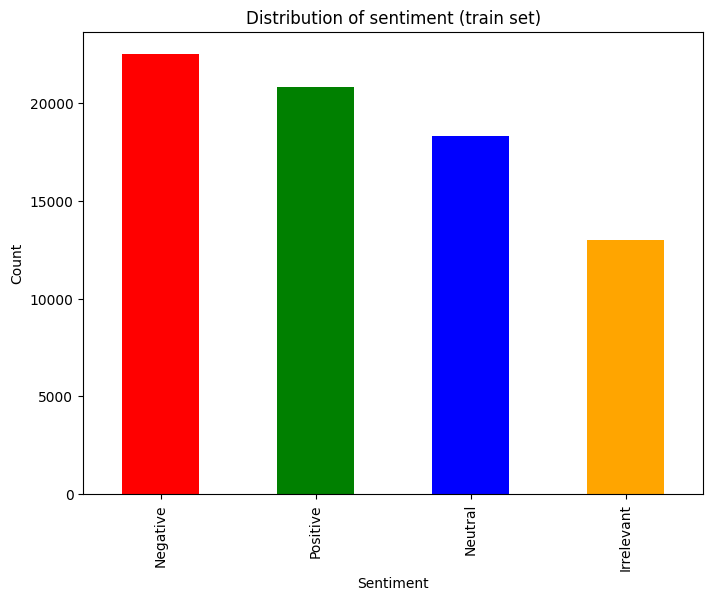

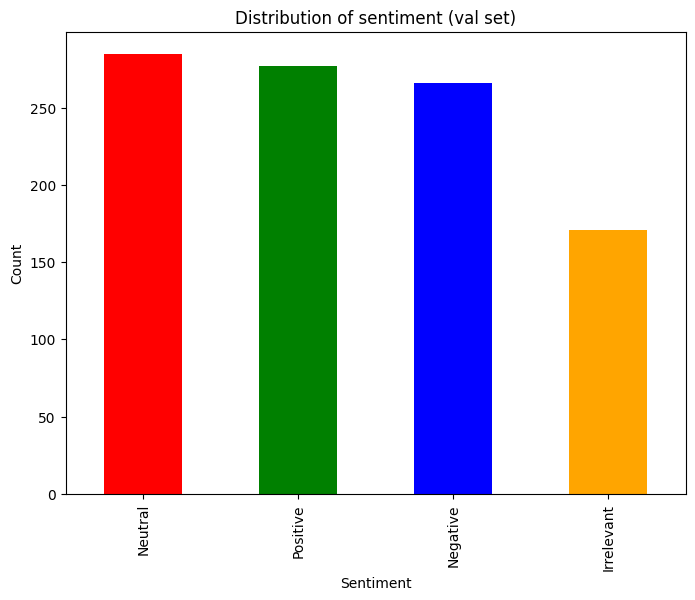

In [4]:
draw_plot(train, 'train')
draw_plot(val, 'val')

In [4]:
def clean_text(text):
    """
    Clean input text by lowercasing and removing punctuation.
    """
    # lower case
    text = text.lower() 
    # remove links
    text = re.compile(r"https?://\S+|www\.\S+").sub("", text)
    # remove punctuations
    table = str.maketrans('','',string.punctuation)
    text = text.translate(table)
    # remove unique char
    text = re.sub(r'(?:^| )\w(?:$| )', ' ',text).strip()
    # contractions
    text = " ".join([contractions.fix(word) for word in text.split()])

    replacements = {
        r"'s\b": "",
        r"\s+": " ",
    }

    for replace, by in replacements.items():
        text = re.sub(replace, by, text)

    return text.strip()

In [5]:
train['tweet_clean'] = train['tweet'].apply(lambda x: clean_text(x))
val['tweet_clean'] = val['tweet'].apply(lambda x: clean_text(x))

In [6]:
def remove_stopwords(text):
    """
    Tokenize text and remove stopwords.
    """
    text = text.apply(word_tokenize)
    text = text.apply(lambda x: [word for word in x if word not in stop_words])
    return text

In [7]:
train['tweet_no_stopwords'] = remove_stopwords(train['tweet_clean'])
train['tweet_no_stopwords'] = train['tweet_no_stopwords'].apply(lambda x: ' '.join(eval(str(x))))
val['tweet_no_stopwords'] = remove_stopwords(val['tweet_clean'])
val['tweet_no_stopwords'] = val['tweet_no_stopwords'].apply(lambda x: ' '.join(eval(str(x))))

# Modelling

In [8]:
X_train = train['tweet_no_stopwords']
#X_train = train.iloc[:, 3].fillna('').astype(str).values
y_train = train['sentiment']
#y_train = train.iloc[:, 2].values 

X_val = val['tweet_no_stopwords']
#X_val = val.iloc[:, 3].fillna('').astype(str).values
y_val = val['sentiment']
#y_val = val.iloc[:, 2].values 

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
class DataStructure:
    def __init__(self,X,typedt,y_train=y_train,y_val=y_val,X_train=X_train,shuffle=True):
        self.X = X
        self.y_train = y_train
        self.y_val = y_val
        self.typedt = typedt
        self.X_train = X_train
        self.shuffle = shuffle

    def encode_data(self):
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(self.y_train)
        y_val = label_encoder.transform(self.y_val)
        if self.typedt == "train":
            return y_train
        else:
            return y_val
    
    def get_tokenizer(self):
        tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
        tokenizer.fit_on_texts(self.X_train)
        return tokenizer
    
    def tokenize_data(self):
        X_seq = self.get_tokenizer().texts_to_sequences(self.X)
        X_pad = pad_sequences(X_seq, maxlen=50, padding='post')
        return X_pad
    
    def tensor_data(self):
        dataset = TensorDataset(torch.tensor(self.tokenize_data(), dtype=torch.long), torch.tensor(self.encode_data(), dtype=torch.long))
        dataloader = DataLoader(dataset, batch_size=64, shuffle=self.shuffle)
        return dataloader


In [11]:
structure = DataStructure(X_train,'train',shuffle=True)
dataloader_train = structure.tensor_data()
structure_val = DataStructure(X_val,'val',shuffle=False)
dataloader_val = structure_val.tensor_data()

In [ ]:
# class FeatureExtractor(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.gru = nn.GRU(8, 64, num_layers=2, batch_first=True)
#         self.fc = nn.Sequential(nn.ReLU(True),
#                                 nn.Linear(64, 64), 
#                                 nn.ReLU(True))
#     def forward(self, x):
#         out, _ = self.gru(x)
#         out = self.fc(out)
#         return out

In [12]:
class GRUModel(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, vocab_size, embedding_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers = 1, bidirectional = False, bias = True, batch_first=True)  
        self.layers = nn.Sequential(
                        nn.GELU(),
                        nn.Linear(hidden_dim, output_dim))
        
    def forward(self, x):
        embedded = self.embedding(x)
        out, _ = self.gru(embedded) # return tuple not tensor
        out = self.layers(out[:, -1, :])
        return out
        

In [ ]:
# class RobertaClass(torch.nn.Module):
#     def __init__(self):
#         super(RobertaClass, self).__init__()
#         self.l1 = RobertaModel.from_pretrained("roberta-base")
#         self.pre_classifier = torch.nn.Linear(768, 768)
#         self.dropout = torch.nn.Dropout(0.3)
#         self.classifier = torch.nn.Linear(768, 5)

#     def forward(self, input_ids, attention_mask, token_type_ids):
#         output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
#         hidden_state = output_1[0]
#         pooler = hidden_state[:, 0]
#         pooler = self.pre_classifier(pooler)
#         pooler = torch.nn.ReLU()(pooler)
#         pooler = self.dropout(pooler)
#         output = self.classifier(pooler)
#         return output

In [ ]:
# # Definindo o modelo GRU
# class GRUClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, vocab_size, embedding_dim):
#         super(GRUClassifier, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.gru_forward = nn.GRU(embedding_dim, hidden_dim, num_layers = 1, bidirectional = False, bias = True, batch_first=True)
#         self.gru_backward = nn.GRU(hidden_dim, hidden_dim, num_layers = 1, bidirectional = False, bias = True, batch_first=True)
#         # self.fc = nn.Linear(hidden_dim, output_dim)
#         self.gelu = nn.GELU()
#         # self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         embedded = self.embedding(x)
#         x, _ = self.gru_forward(embedded)
#         x = self.gelu(x[:, -1, :])
#         x = torch.flip(x, dims=[1])
#         x, _ = self.gru_backward(x)
#         x = torch.flip(x, dims=[1])
#         out = self.gelu(x)
#         #out = out[:, -1, :]  # Pegando a última saída da GRU
#         #out = self.fc(out)
#         return out

In [ ]:
# class BGRUModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes, vocab_size, embedding_dim):
#         super(BGRUModel, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.bgru = nn.GRU(embedding_dim, hidden_size, num_layers, bidirectional=True)
#         self.fc = nn.Linear(hidden_size * 2, num_classes)

#     def forward(self, x):
#         out, _ = self.bgru(x)
#         out = self.fc(out[:, -1, :])  
#         return out

In [ ]:
# class GRUClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, vocab_size, embedding_dim):
#         super(GRUClassifier, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         embedded = self.embedding(x)
#         gru_out, _ = self.gru(embedded)
#         gru_out = gru_out[:, -1, :]  # Pegando a última saída da GRU
#         out = self.fc(gru_out)
#         return out

In [13]:
vocab_size = 10000
embedding_dim = 64
hidden_dim = 128
output_dim = 4

In [14]:
model_gru = GRUModel(hidden_dim=hidden_dim, output_dim=output_dim, vocab_size=vocab_size, embedding_dim=embedding_dim)
model_gru.to(device)

GRUModel(
  (embedding): Embedding(10000, 64)
  (gru): GRU(64, 128, batch_first=True)
  (layers): Sequential(
    (0): GELU(approximate='none')
    (1): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [ ]:
# model = GRUClassifier(input_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, vocab_size=vocab_size, embedding_dim=embedding_dim)
# model.to(device)

GRUClassifier(
  (embedding): Embedding(10000, 64)
  (gru_forward): GRU(64, 128, batch_first=True)
  (gru_backward): GRU(128, 128, batch_first=True)
  (gelu): GELU(approximate='none')
)

In [24]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
# metrics_callback = train_model(model, dataloader_train, dataloader_val, criterion, optimizer, epochs=20, patience=3, min_delta=0.001)

In [26]:
# def calcuate_accuracy(preds, targets):
#     n_correct = (preds==targets).sum().item()
#     return n_correct

# loss_function = torch.nn.CrossEntropyLoss()

In [24]:
import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
# from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
# from pytorch_lightning.loggers import TensorBoardLoggerwhich 
from torchmetrics.functional import accuracy

In [ ]:
# class LightningTransformer(L.LightningModule):
#     def __init__(self, vocab_size):
#         super().__init__()
#         self.model = Transformer(vocab_size=vocab_size)

#     def forward(self, inputs, target):
#         return self.model(inputs, target)

#     def training_step(self, batch, batch_idx):
#         inputs, target = batch
#         output = self(inputs, target)
#         loss = torch.nn.functional.nll_loss(output, target.view(-1))
#         return loss

#     def configure_optimizers(self):
#         return torch.optim.SGD(self.model.parameters(), lr=0.1)

In [36]:
class TrainModel(pl.LightningModule):
  def __init__(self, model): 
    super(TrainModel,self).__init__()
    self.model = model
    self.criterion = nn.CrossEntropyLoss()

  def forward(self, x):
        return self.model(x) #inputs
  
  def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss

  def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss, prog_bar=True, logger=True)
        return loss
  
#   def test_step(self, batch, batch_idx):
#         loss = self(batch).sum()
#         self.log("test_loss", loss)
  def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)
  
#   def predict_step(self, batch):
#         inputs, target = batch
#         return self.model(inputs, target)
  def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)

#   def training_epoch_end(self, outputs):
#       labels = []
#       predictions = []
#       for output in outputs:
#             for out_labels in output["labels"].detach().cpu():
#                   labels.append(out_labels)
#             for out_predictions in output["predictions"].detach().cpu():
#                   predictions.append(out_predictions)

#       labels = torch.stack(labels).int()
#       predictions = torch.stack(predictions)

#       for i, name in enumerate(LABEL_COLUMNS):
#             class_roc_auc = auroc(predictions[:, i], labels[:, i])
#             self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_r)
                                              

  def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer

In [30]:
# from tensorflow.keras.callbacks import ModelCheckpoint

In [45]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
np.Inf = np.inf

early_stop_callback = EarlyStopping(
    monitor = "val_loss", 
    min_delta = 0.00, 
    patience = 10, 
    verbose = False, 
    mode = "min",
)

# checkpoint_callback = ModelCheckpoint(save_top_k = 1, monitor = "val_loss",
#                                       dirpath = './best_model', filename='best',
#                                       save_last=True
#                                       )


# checkpoint_callback = ModelCheckpoint(dirpath="checkpoints", # where the ckpt will be saved
#                                       filename="best-checkpoint", # the name of the best ckpt
#                                       save_top_k=1, # save only the best ckpt
#                                       verbose=True,
#                                       monitor="val_loss", # ckpt will be save according to the validation loss that you need to calculate on the validation step when you train your model
#                                       mode="min" # validation loos need to be min
#                                       ) 

# checkpoint_callback = ModelCheckpoint(
#                     dirpath="checkpoints", filename="best-checkpoint",
#                     save_top_k=1, verbose=True, monitor="val_loss", mode="min")

# checkpoint_callback = ModelCheckpoint(dirpath="checkpoints", # where the ckpt will be saved
#                                       filename="best-checkpoint", # the name of the best ckpt
#                                       save_top_k=1, # save only the best ckpt
#                                       verbose=True,
#                                       monitor="Validation loss", # ckpt will be save according to the validation loss that you need to calculate on the validation step when you train your model
#                                       mode="min" # validation loos need to be min
#                                       ) 

logger = TensorBoardLogger("lightning_logs", name="sentiment")




# checkpoint_callback = ModelCheckpoint(
#         monitor='val_loss',
#         dirpath='.\lightning_logs',
#         filename='sample-mnist-epoch{epoch:02d}-val_loss{val/loss:.2f}',
#         auto_insert_metric_name=False
#  )
# filepath="./lightning_logs/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.ckpt"
# checkpoint_callback = pl.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min') #, save_best_only=True


checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=10,
    monitor="val_loss",
    mode="min",
    dirpath='./lightning_logs',
    filename="sample-mnist-{epoch:02d}-{val_loss:.2f}",
)

model = TrainModel(model_gru) 
trainer = pl.Trainer(max_epochs = 1, accelerator = 'cpu',
                     logger=logger,
                     #callbacks=[early_stop_callback, checkpoint_callback], 
                     default_root_dir = './lightning_logs',
                     callbacks = [early_stop_callback, checkpoint_callback], # [early_stop_callback], #
                    val_check_interval = len(dataloader_train)) 

trainer.fit(model = model, train_dataloaders = dataloader_train)
trainer.save_checkpoint("./lightning_logs/example.ckpt")
trainer.test(model, dataloaders = dataloader_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | GRUModel         | 715 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
715 K     Trainable params
0         Non-trainable params
715 K     Total params
2.860     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1157/1157 [01:10<00:00, 16.33it/s, loss=0.131, v_num=12, train_loss=0.0688]

`Trainer.fit` stopped: `max_epochs=1` reached.


Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 52.39it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.24870845675468445    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.24870845675468445}]

In [50]:
new_model = model.load_from_checkpoint(checkpoint_path="./lightning_logs/example.ckpt")
# trainer.predict(dataloaders = dataloader_val)
new_model.predict(dataloaders = dataloader_val)

TypeError: TrainModel.__init__() missing 1 required positional argument: 'model'

In [ ]:
# Train the model
# trainer.fit(model_gru, dataloader_train, dataloader_val)
# trainer.fit(model = model, train_dataloaders = dataloader_train)

# trainer.fit(model, train_dataloaders = dataloader_train, val_dataloaders = dataloader_val)


  | Name      | Type             | Params
-----------------------------------------------
0 | model     | GRUModel         | 715 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
715 K     Trainable params
0         Non-trainable params
715 K     Total params
2.860     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1157/1157 [00:42<00:00, 26.98it/s, loss=1.02, v_num=1, train_loss=1.320] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1157/1157 [00:42<00:00, 26.98it/s, loss=1.02, v_num=1, train_loss=1.320]


In [148]:
# trainer.test()

In [36]:
# automatically auto-loads the best weights from the previous run
#trainer.test(dataloaders = dataloader_val, ckpt_path = "best")
trainer.test(model, dataloaders = dataloader_val)
trainer.predict(dataloaders = dataloader_val)

Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 64.96it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.9058710932731628     │
└───────────────────────────┴───────────────────────────┘

MisconfigurationException: `.predict(ckpt_path="best")` is set but `ModelCheckpoint` is not configured to save the best model.

In [37]:
trained_model = TrainModel.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  model_gru
)

trained_model.eval()
trained_model.freeze()

PermissionError: [Errno 13] Permission denied: 'c:/Users/annag/Desktop/Data Science/Sentiment Analysis'

In [143]:

# automatically auto-loads the best weights from the previous run
# predictions = trainer.predict(dataloaders = dataloader_val)
predictions = trainer.predict(model, dataloaders=dataloader_val)

Predicting DataLoader 0:   0%|          | 0/16 [00:00<?, ?it/s]

TypeError: TrainModel.predict_step() takes 2 positional arguments but 3 were given

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5, patience=3, min_delta=0.001):
    metrics_callback = MetricsCallback()
    early_stopping = ValidationLossEarlyStopping(patience=patience, min_delta=min_delta)  
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        all_train_preds = []
        all_train_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            all_train_preds.append(outputs.detach())
            all_train_labels.append(labels.detach())

        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                all_val_preds.append(outputs)
                all_val_labels.append(labels)

        all_train_preds = torch.cat(all_train_preds)
        all_train_labels = torch.cat(all_train_labels)
        all_val_preds = torch.cat(all_val_preds)
        all_val_labels = torch.cat(all_val_labels)

        # Atualizando as métricas ao final de cada época
        metrics_callback.update_metrics(
            epoch,
            all_train_labels.cpu().numpy(),
            all_train_preds.cpu(),
            all_val_labels.cpu().numpy(),
            all_val_preds.cpu(),
            train_loss / len(train_loader),
            val_loss / len(val_loader)
        )

        # Verificar Early Stopping com base no val_loss
        early_stopping(val_loss / len(val_loader))
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Retornando as métricas ao final do treinamento para plotar
    return metrics_callback

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [120]:
class ValidationLossEarlyStopping:
    def __init__(self, patience=1, min_delta=0.0):
        self.patience = patience  # number of times to allow for no improvement before stopping the execution
        self.min_delta = min_delta  # the minimum change to be counted as improvement
        self.counter = 0  # count the number of times the validation accuracy not improving
        self.min_validation_loss = np.inf

    # return True when validation loss is not decreased by the `min_delta` for `patience` times 
    def early_stop_check(self, validation_loss):
        if ((validation_loss+self.min_delta) < self.min_validation_loss):
            self.min_validation_loss = validation_loss
            self.counter = 0  # reset the counter if validation loss decreased at least by min_delta
        elif ((validation_loss+self.min_delta) > self.min_validation_loss):
            self.counter += 1 # increase the counter if validation loss is not decreased by the min_delta
            if self.counter >= self.patience:
                return True
        return False


In [23]:
from sklearn.metrics import f1_score, precision_score, recall_score

class MetricsCallback:
    def __init__(self):
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_f1 = []
        self.val_f1 = []
        self.train_precision = []
        self.val_precision = []
        self.train_recall = []
        self.val_recall = []
        self.train_loss = []
        self.val_loss = []

    def update_metrics(self, epoch, y_true_train, y_pred_train, y_true_val, y_pred_val, train_loss, val_loss):
        y_pred_train = torch.argmax(y_pred_train, dim=1).cpu().numpy()
        y_pred_val = torch.argmax(y_pred_val, dim=1).cpu().numpy()

        # Calculando as métricas para o conjunto de treino
        train_acc = (y_true_train == y_pred_train).mean()
        train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')
        train_precision = precision_score(y_true_train, y_pred_train, average='weighted')
        train_recall = recall_score(y_true_train, y_pred_train, average='weighted')

        # Calculando as métricas para o conjunto de validação
        val_acc = (y_true_val == y_pred_val).mean()
        val_f1 = f1_score(y_true_val, y_pred_val, average='weighted')
        val_precision = precision_score(y_true_val, y_pred_val, average='weighted')
        val_recall = recall_score(y_true_val, y_pred_val, average='weighted')

        # Armazenando as métricas e a perda
        self.train_accuracy.append(train_acc)
        self.val_accuracy.append(val_acc)
        self.train_f1.append(train_f1)
        self.val_f1.append(val_f1)
        self.train_precision.append(train_precision)
        self.val_precision.append(val_precision)
        self.train_recall.append(train_recall)
        self.val_recall.append(val_recall)
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)

        # Exibindo as métricas no final de cada época
        print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")

In [ ]:
https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html
https://www.kaggle.com/code/jvrco22/twitter-sentiment-analysis-96-val-acc#Models

https://www.reddit.com/r/learnpython/comments/fayicq/vscode_the_term_conda_is_not_recognized_as_the/?rdt=49293


SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (2885270193.py, line 1)